# Deepfake Detection
## Preprocessing
### CSEC620 - Project 3 - Vaibhav Savala

### Import Required Libraries

In [ ]:
import os
from moviepy.editor import VideoFileClip
import cv2
import dlib

# Preprocessing Videos
- Convert to H.264

```
for %i in (*.mp4) do (
    ffmpeg -i "%i" -c:v libx264 -preset medium -crf 23 "temp_%i"
    move /Y "temp_%i" "%i"
)
```

- Trim each video to be 10 seconds long
- Rename Manipulated folders to be the same as original folder files


In [ ]:
def trim_videos(folder_path):
    output_folder = 'Dataset/Manipulated/Trimmed/'  # Specify the output folder

    for filename in os.listdir(folder_path):
        print("Trimming", filename, "in", folder_path)
        if filename.endswith('.mp4'):
            input_filepath = os.path.join(folder_path, filename)
            output_filepath = os.path.join(output_folder, filename)  # Save as a new file

            try:
                with VideoFileClip(input_filepath) as video:
                    trimmed_clip = video.subclip(0, 10)  # Trim the first 10 seconds
                    trimmed_clip.write_videofile(output_filepath, codec='libx264')
                    trimmed_clip.close()  # Explicitly close the clip
            except Exception as e:
                print(f"Error processing {filename}: {e}")



def rename_videos(directory):
    # List all files in the directory
    files = os.listdir(directory)
    print("Renaming files in ", directory)
    for file in files:
        # Check if the file is an mp4 file
        if file.endswith('.mp4'):
            # Get the first three characters of the filename
            new_name = file[:3] + '.mp4'
            # Renaming the file
            os.rename(os.path.join(directory, file), os.path.join(directory, new_name))

#rename_videos('Dataset/Original/')
#rename_videos('Dataset/Manipulated/')
#trim_videos('Dataset/Original/')
#trim_videos('Dataset/Manipulated/')

In [ ]:
# Extract evenly spaced frames from videos
def extract_frames(video_path, output_folder, num_frames=10):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Extract the base filename without extension
    base_filename = os.path.splitext(os.path.basename(video_path))[0]

    vidcap = cv2.VideoCapture(video_path)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames / (num_frames - 1)  # Adjust the interval calculation
    frames_to_capture = [int(interval * i) for i in range(num_frames)]

    count = 0
    frame_number = 1  # Start numbering frames from 1
    success, image = vidcap.read()

    while success:
        if count in frames_to_capture:
            # Use the base filename in the saved file name
            cv2.imwrite(os.path.join(output_folder, f"{base_filename}_{frame_number}.jpg"), image)
            frame_number += 1  # Increment the frame number
            if len(frames_to_capture) == 0:  # Break once all required frames are captured
                break
            frames_to_capture.remove(count)
        success, image = vidcap.read()
        count += 1

# Detect faces in images
def detect_faces(image):
    detector = dlib.get_frontal_face_detector()
    faces = detector(image, 1)
    face_images = []
    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        face_img = image[y:y+h, x:x+w]
        face_images.append(face_img)
    return face_images

def show_images(images, titles, cols=5):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(15, rows * 3))

    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(titles[i] if i < len(titles) else '')
        plt.xticks([]), plt.yticks([])

    plt.show()

def random_video_display(original_videos_path, deepfake_videos_path):
    random_video = random.choice(os.listdir(original_videos_path))
    print("Randomly selected video: ", random_video)
    original_video_path = os.path.join(original_videos_path, random_video)
    deepfake_video_path = os.path.join(deepfake_videos_path, random_video)

    # Display original frames
    extract_frames(original_video_path, 'temp_frames')
    original_frames = [cv2.imread(os.path.join('temp_frames', f)) for f in os.listdir('temp_frames')]
    show_images(original_frames, ['Original Frame'] * len(original_frames), 5)

    # Display faces from original frames
    original_faces = []
    for frame in original_frames:
        original_faces.extend(detect_faces(frame))
    show_images(original_faces, ['Original Face'] * len(original_faces), 5)

    # Display deepfake frames
    extract_frames(deepfake_video_path, 'temp_frames_deepfake')
    deepfake_frames = [cv2.imread(os.path.join('temp_frames_deepfake', f)) for f in os.listdir('temp_frames_deepfake')]
    show_images(deepfake_frames, ['Deepfake Frame'] * len(deepfake_frames), 5)

    # Display faces from deepfake frames
    deepfake_faces = []
    for frame in deepfake_frames:
        deepfake_faces.extend(detect_faces(frame))
    show_images(deepfake_faces, ['Deepfake Face'] * len(deepfake_faces), 5)

def extract_frames_from_videos(original_videos_path, output_folder):
    for video_file in os.listdir(original_videos_path):
        print("Extracting frames from", video_file)
        video_path = os.path.join(original_videos_path, video_file)
        extract_frames(video_path, output_folder)

def extract_faces_from_frames(frames_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for frame_file in os.listdir(frames_folder):
        # Extract the base filename without extension
        base_frame_name = os.path.splitext(os.path.basename(frame_file))[0]

        print("Extracting faces from", frame_file)
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)
        faces = detect_faces(frame)
        for i, face in enumerate(faces):
            if face is not None and not face.size == 0:
                cv2.imwrite(os.path.join(output_folder, f"{base_frame_name}_{i}.jpg"), face)
            else:
                print(f"No face detected in {frame_file} or face is empty.")

def load_faces(folder_path, X, y, label, target_size=(224, 224)):
    for filename in os.listdir(folder_path):
        print("Loading", filename)
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, target_size)
                X.append(img_resized)
                y.append(label)
            else:
                print(f"Failed to load image: {img_path}")
    return X, y

Randomly selected video:  972.mp4


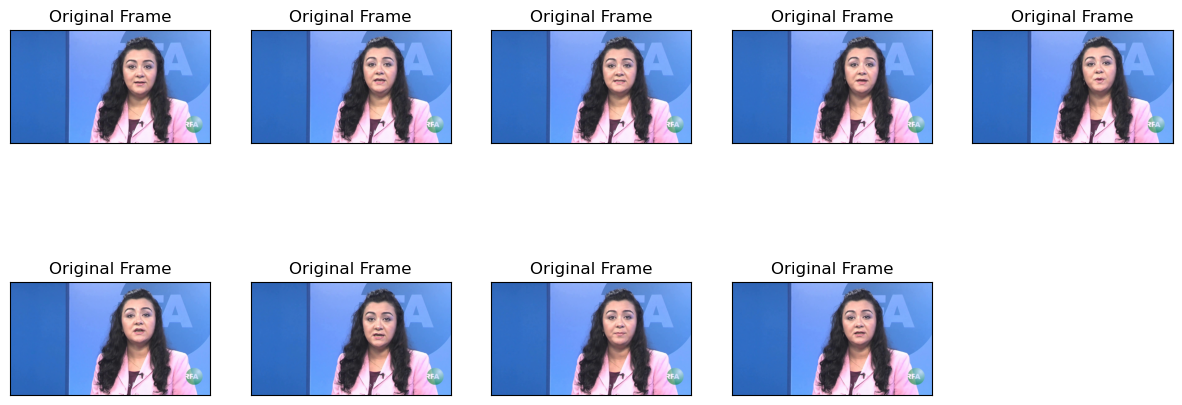

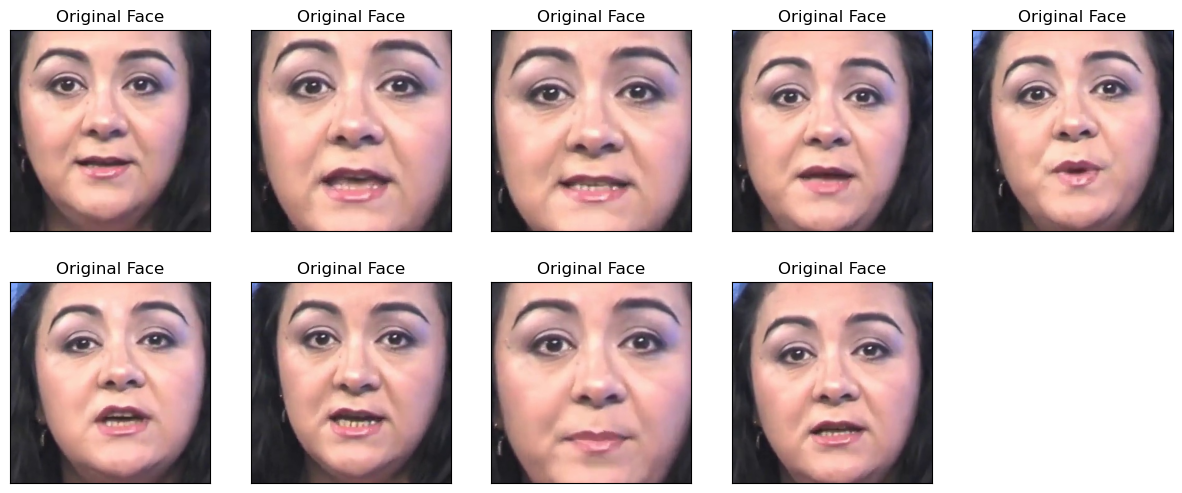

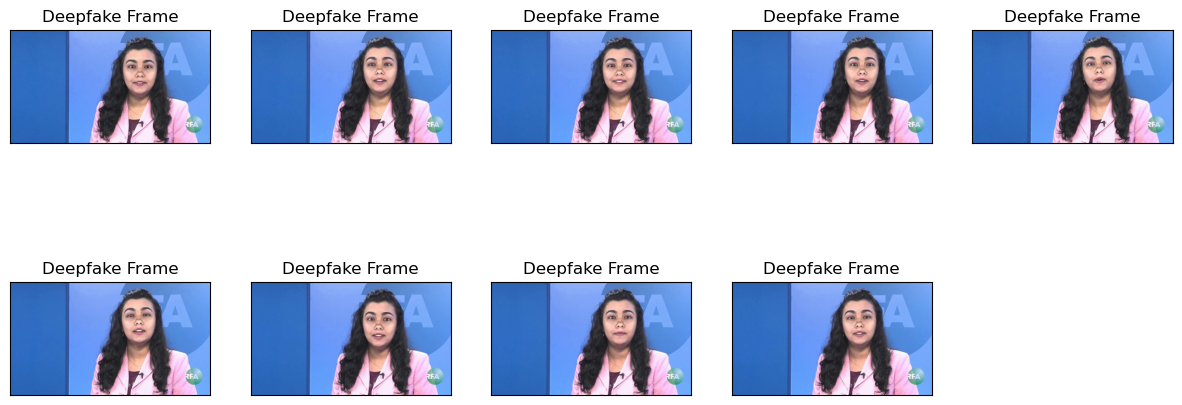

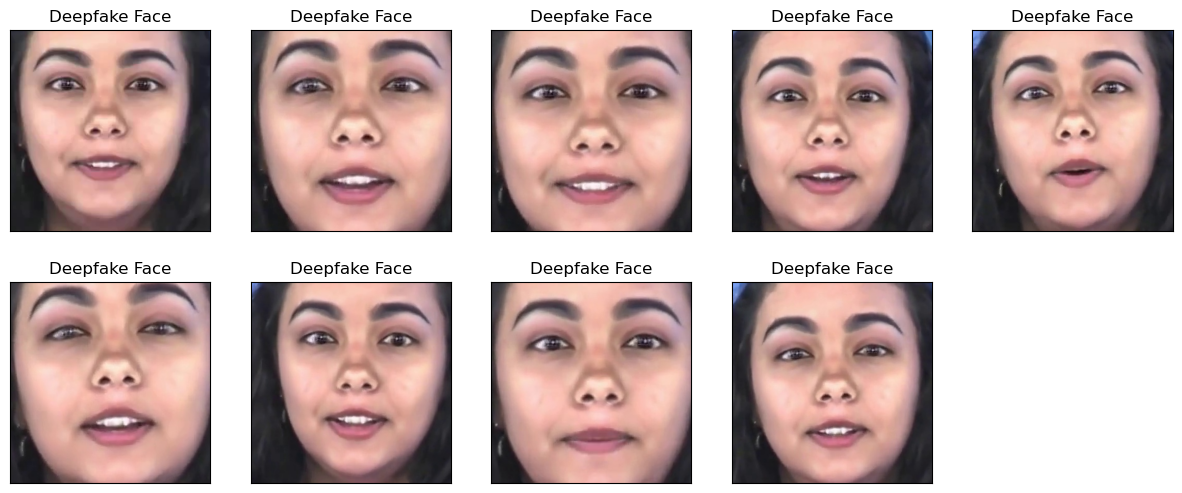

In [ ]:
original_videos_path = 'Dataset/Original/'
deepfake_videos_path = 'Dataset/Manipulated/'

X = []
y = []

random_video_display(original_videos_path, deepfake_videos_path)
#extract_frames_from_videos(original_videos_path, 'temp_frames_original')
#extract_frames_from_videos(deepfake_videos_path, 'temp_frames_manipulated')
#extract_faces_from_frames('temp_frames_original', 'temp_faces_original')
#extract_faces_from_frames('temp_frames_manipulated', 'temp_faces_manipulated')

#X, y = load_faces('temp_faces_original', X, y, 0)
#X, y = load_faces('temp_faces_manipulated', X, y, 1)

# Convert lists to numpy arrays
#X = np.array(X)
#y = np.array(y)

#X_file = 'Dataset/X_data.npy'
#Y_file = 'Dataset/Y_data.npy'

# Save the dataset
#np.save(X_file, X)
#np.save(Y_file, y)